<a href="https://colab.research.google.com/github/olonok69/NEO4J/blob/main/NEO4J_02_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py2neo==4.1.3 pandas matplotlib sklearn

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 194kB 14.1MB/s 
     |████████████████████████████████| 256kB 23.1MB/s 
     |████████████████████████████████| 133kB 24.5MB/s 
  Created wheel for py2neo: filename=py2neo-4.1.3-py2.py3-none-any.whl size=89805 sha256=733f24046158ae76996b9f81ad6b1dea587929f2880c013ae9133eb5a704ac5b
  Stored in directory: /root/.cache/pip/wheels/49/b4/f8/df22db284f7ec2f6c26f87a87ff38c6c8ffa84baf2930ef0fe
  Created wheel for neo4j-driver: filename=neo4j_driver-1.6.3-cp36-cp36m-linux_x86_64.whl size=525054 sha256=f56025927b64449f9a7df93a97606bcdead9fbef2a213c7c87348fe82586694f
  Stored in directory: /root/.cache/pip/wheels/e3/3d/6f/b1afb54585268913bb38334adaa58c2938911edc85102803a1
  Created wheel for neotime: filename=neotime-1.0.0-cp36-none-any.whl size=14714 sha256=d735854bf0f1f31e088cbbabb3a14b9b15dfa37688576bfc922fb237e5b1e9cd
  Stored in directory: /root/.cache/pip/wheels/19/1c/63/e1777cae4998cb32c5ae5bb1901

# Exploratory Data Analysis

In this notebook you will explore the citation dataset. You should already have installed py2neo, pandas, and matplotlib when setting up our environment, so you will now import them (remember to unset Reset all runtimes before running):

In [ ]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Next, create a connection to your Neo4j Sandbox, just as you did previously when you set up your environment. 

<div align="left">
    <img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/sandbox-citations.png?raw=1" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.

In [ ]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
from py2neo import Graph 
graph = Graph("bolt://100.26.229.35:34820", auth=("neo4j", "dares-problems-concurrence"))

## What's in our database?

Run the following query to check how many nodes our database contains:

In [ ]:
graph.run("CALL db.schema()").data()

[{'nodes': [(_-3:Venue {constraints: ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE'], indexes: [], name: 'Venue'}),
   (_-1:Article {constraints: ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE'], indexes: [], name: 'Article'}),
   (_-2:Author {constraints: ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE'], indexes: [], name: 'Author'})],
  'relationships': [(Article)-[:VENUE {}]->(Venue),
   (Article)-[:AUTHOR {}]->(Author),
   (Article)-[:CITED {}]->(Article)]}]

If we run that query (CALL db.schema()) in  Neo4j Browser, you see the following visualisation:

<img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/data-science-training.png?raw=1" alt="Graph Data Model"/>


Let's drill down a bit. How many nodes do we have for each of these labels? Run this code:

In [ ]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


You can visualize the counts using matplotlib> Run the following code:

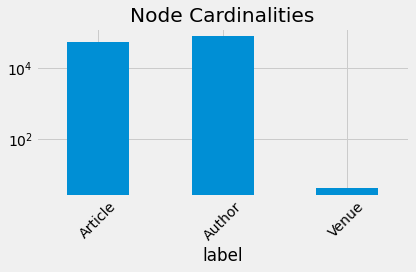

In [ ]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

What types of relationships do we have in our graph? Run this code:

In [ ]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


You can visualize the counts using matplotlib. Run  the following code:

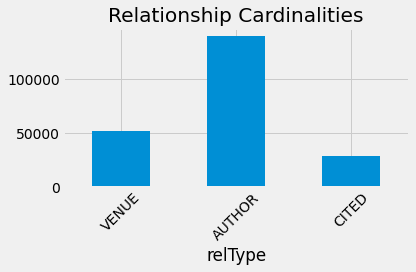

In [ ]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now let's explore the citation data. The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by.
Run this code:

In [ ]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY rand()
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,venue,citationsGiven,citationsReceived
0,Residual test coverage monitoring,Christina Pavlopoulou,international conference on software engineering,0,13
1,Parallel computing on any desktop,Ami Marowka,Communications of The ACM,0,0
2,Sensor data scheduling for linear quadratic Ga...,Ling Shi,advances in computing and communications,0,1
3,Efficient topology optimization for a wired ne...,Hengtao Wang,advances in computing and communications,0,0
4,Object-Oriented Mediator Queries to Internet S...,Simon Zürcher,Lecture Notes in Computer Science,0,0
5,Tools for the Workplace.,Brigitte Jordan,Communications of The ACM,0,0
6,A novel particle filter parameter prediction s...,Nader Meskin,advances in computing and communications,0,0
7,Distributed economic model predictive control ...,James B. Rawlings,advances in computing and communications,1,0
8,Optimal thermostat programming and optimal ele...,Matthew M. Peet,advances in computing and communications,1,0
9,Coverability of Reset Petri Nets and Other Wel...,Michael Leuschel,Lecture Notes in Computer Science,1,1


Let's look into the citation data more closely. Here is a query that returns the number of citations that each article has, and then creates a distribution of those counts using pandas `describe` function. Run this code:

In [ ]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000
mean,0.553
std,2.418
min,0.000
25%,0.000
50%,0.000
75%,0.000
90%,1.000
99%,8.000
max,211.000


Most articles are being cited very few times. 99% of articles have 8 citations or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data. Run this code:

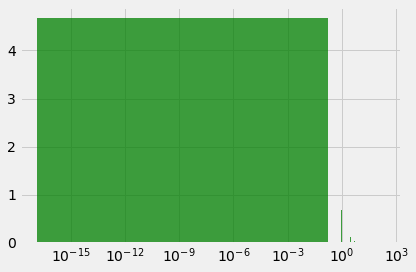

In [ ]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1250, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Exercise instructions

1. Create a similar query showing the articles that cite the most other papers? Note that you'll only need to do a slight tweak of the Cypher query to do this. 
2. What about a distribution of the number of articles published by authors?

Keep the results of this exercise handy as they may be useful for the quiz at the end of this module.

In [ ]:
# 1
query = """
MATCH (a:Article)
RETURN size((a)-[:CITED]->()) AS cited
"""

cited_df = graph.run(query).to_data_frame()
cited_df.describe([.25, .5, .75, .9, .99])

,cited
count,51956.000
mean,0.553
std,1.301
min,0.000
25%,0.000
50%,0.000
75%,1.000
90%,2.000
99%,6.000
max,51.000


In [ ]:
#2
query = """
MATCH (a:Author)
RETURN size((a)<-[:AUTHOR]-()) AS published
"""

published_df = graph.run(query).to_data_frame()
published_df.describe([.25, .5, .75, .9, .99])

,published
count,80299.000
mean,1.751
std,2.064
min,1.000
25%,1.000
50%,1.000
75%,2.000
90%,3.000
99%,10.000
max,89.000


In [ ]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, author.name AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY citationsGiven DESC
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame()

,article,author,venue,citationsGiven,citationsReceived
0,Translator writing systems,David Gries,Communications of The ACM,51,17
1,Translator writing systems,Jerome A. Feldman,Communications of The ACM,51,17
2,Curriculum 68: Recommendations for academic pr...,William B. Kehl,Communications of The ACM,50,14
3,Curriculum 68: Recommendations for academic pr...,Samuel D. Conte,Communications of The ACM,50,14
4,Curriculum 68: Recommendations for academic pr...,Silvio O. Navarro,Communications of The ACM,50,14
5,Curriculum 68: Recommendations for academic pr...,Earl J. Schweppe,Communications of The ACM,50,14
6,Curriculum 68: Recommendations for academic pr...,T. E. Hull,Communications of The ACM,50,14
7,Curriculum 68: Recommendations for academic pr...,David M. Young,Communications of The ACM,50,14
8,Curriculum 68: Recommendations for academic pr...,Werner C. Rheinboldt,Communications of The ACM,50,14
9,Curriculum 68: Recommendations for academic pr...,Thomas A. Keenan,Communications of The ACM,50,14
